In [1]:
import numpy as np 
import pandas as pd 
import os
import sklearn
import re
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

In [2]:
train = pd.read_csv('bollywood_data.csv')
train

,title_x,imdb_id,poster_path,wiki_link,title_y,original_title,is_adult,year_of_release,runtime,genres,imdb_rating,imdb_votes,story,summary,tagline,actors,wins_nominations,release_date,budget,box office
0,Uri: The Surgical Strike,tt8291224,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Uri:_The_Surgica...,Uri: The Surgical Strike,Uri: The Surgical Strike,0,2019,138,Action|Drama|War,8.4,35112,Divided over five chapters the film chronicles...,Indian army special forces execute a covert op...,NaN,Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...,4 wins,11 January 2019 (USA),25.00,342.06
1,Battalion 609,tt9472208,NaN,https://en.wikipedia.org/wiki/Battalion_609,Battalion 609,Battalion 609,0,2019,131,War,4.1,73,The story revolves around a cricket match betw...,The story of Battalion 609 revolves around a c...,NaN,Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...,NaN,11 January 2019 (India),0.01,2.70
2,The Accidental Prime Minister (film),tt6986710,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/The_Accidental_P...,The Accidental Prime Minister,The Accidental Prime Minister,0,2019,112,Biography|Drama,6.1,5549,Based on the memoir by Indian policy analyst S...,Explores Manmohan Singh's tenure as the Prime ...,NaN,Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...,NaN,11 January 2019 (USA),18.00,22.65
3,Why Cheat India,tt8108208,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Why_Cheat_India,Why Cheat India,Why Cheat India,0,2019,121,Crime|Drama,6.0,1891,The movie focuses on existing malpractices in ...,The movie focuses on existing malpractices in ...,NaN,Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...,NaN,18 January 2019 (USA),20.00,10.54
4,Evening Shadows,tt6028796,NaN,https://en.wikipedia.org/wiki/Evening_Shadows,Evening Shadows,Evening Shadows,0,2018,102,Drama,7.3,280,While gay rights and marriage equality has bee...,Under the 'Evening Shadows' truth often plays ...,NaN,Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...,17 wins & 1 nomination,11 January 2019 (India),2.75,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,Samadhi (1950 film),tt0268614,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Samadhi_(1950_film),Samadhi,Samadhi,0,1950,165,Drama,6.1,21,The story is based on the true incident at INA...,The story is based on the true incident at INA...,NaN,Ashok Kumar|Nalini Jaywant|Kuldip Kaur|Shyam|M...,NaN,NaN,NaN,NaN
4325,Sangram (1950 film),tt0244182,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Sangram_(1950_film),Sangram,Sangram,0,1950,139,Drama,6.2,20,After the death of his wife a policeman fails ...,After the death of his wife a policeman fails ...,NaN,Ashok Kumar|Nalini Jaywant|Nawab|Sajjan|Tiwari...,NaN,NaN,NaN,NaN
4326,Sargam (1950 film),tt0269826,NaN,https://en.wikipedia.org/wiki/Sargam_(1950_film),Melody,Sargam,0,1950,135,Drama|Family,6.8,21,NaN,Add a Plot »,NaN,Raj Kapoor|Rehana|Om Prakash|David Abraham|Rad...,NaN,4 February 1957 (Iran),NaN,NaN
4327,Sheesh Mahal (1950 film),tt0243555,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Sheesh_Mahal_(19...,Sheesh Mahal,Sheesh Mahal,0,1950,144,Drama,7.0,13,Thakur Jaspal Singh lives in the prestigious a...,Thakur Jaspal Singh lives in the prestigious a...,NaN,Sohrab Modi|Naseem Banu|Pushpa Hans|Nigar Sult...,NaN,NaN,NaN,NaN


In [3]:
#Droping columns which are not useful
train = train.drop(['title_x','title_y', 'imdb_id', 'poster_path', 'wiki_link', 'is_adult', 'tagline', 'release_date', 'story', 'summary'], axis=1)

In [4]:
#Renaming columns for ease of references
train = train.rename(columns={'original_title':'title', 'year_of_release':'year', 'imdb_rating':'rating', 'imdb_rating':'rating', 'imdb_votes':'votes', 'wins_nominations':'awards'})


In [5]:
#Data cleaning
train['box_office'] = train['box office']
train = train.drop(['box office'], axis = 1)
train['awards'] = train['awards'].apply(lambda x : re.sub(r'[A-Za-z]', '', str(x)))

train[['wins', 'nominations']] = train.awards.str.split('&', expand= True)

train['wins'] = train['wins'].str.strip()
train['wins'] = train['wins'].apply(lambda x: 0 if x=='' else x)
train['wins'] = train['wins'].replace(np.nan, 0)
train['wins'] = train['wins'].astype(int)
train['nominations'] = train['nominations'].replace(np.nan, 0)
train['nominations'] = train['nominations'].astype(int)

train['runtime'] = train['runtime'].replace('\\N', np.nan)
train['runtime'] = train['runtime'].ffill()
train['runtime'] = train['runtime'].astype(int)
train = train[train['runtime'] >= 60]

actors = train.actors.str.split('|', expand=True)
train['lead_actor'] = actors[0]

train[['genre', 'genre2', 'genre3']] = train.genres.str.split("|", expand=True)
train[['lead_actor1', 'lead_actor2', 'lead_actor3', 'lead_actor4']] = train.actors.str.split("|", expand=True)[[0,1,2,3]]
train.drop(['genres', 'awards', 'actors', 'genre2', 'genre3', 'nominations'], axis=1)
minor_genre_list = ['Animation', 'Documentary', 'History', 'Music', 'War', 'Sci-Fi', 'Sport']
train = train[~train['genre'].isin(minor_genre_list)]

train = train.drop(['awards', 'genres','lead_actor','actors'], axis=1)
train = train[train['year'] >= 2009]
train = train.drop_duplicates()

train["success"] = np.where(
   (train.box_office > train.budget), 
   "1", 
   "0"
)
train['success'] = train['success'].astype(int)

In [6]:
train

,title,year,runtime,rating,votes,budget,box_office,wins,nominations,genre,genre2,genre3,lead_actor1,lead_actor2,lead_actor3,lead_actor4,success
0,Uri: The Surgical Strike,2019,138,8.4,35112,25.00,342.06,4,0,Action,Drama,War,Vicky Kaushal,Paresh Rawal,Mohit Raina,Yami Gautam,1
2,The Accidental Prime Minister,2019,112,6.1,5549,18.00,22.65,0,0,Biography,Drama,None,Anupam Kher,Akshaye Khanna,Aahana Kumra,Atul Sharma,1
3,Why Cheat India,2019,121,6.0,1891,20.00,10.54,0,0,Crime,Drama,None,Emraan Hashmi,Shreya Dhanwanthary,Snighdadeep Chatterji,Navneet Srivastava,0
4,Evening Shadows,2018,102,7.3,280,2.75,2.50,17,1,Drama,None,None,Mona Ambegaonkar,Ananth Narayan Mahadevan,Devansh Doshi,Arpit Chaudhary,0
5,Soni,2018,97,7.2,1595,0.50,0.10,3,5,Drama,None,None,Geetika Vidya Ohlyan,Saloni Batra,Vikas Shukla,Mohit Chauhan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,4.0,7266,80.00,120.00,1,3,Action,Comedy,None,Mithun Chakraborty,Akshay Kumar,Deepika Padukone,Ranvir Shorey,1
970,Familywala,2014,180,5.8,57,6.00,3.00,0,0,Comedy,Drama,Romance,Arjun Rampal,Dia Mirza,Ashok Saraf,Shoma Anand,0
971,Sunglass,2013,100,6.5,24,8.00,5.00,0,0,Comedy,Drama,Thriller,Jaya Bachchan,Madhavan,Tota Roy Chowdhury,Raima Sen,0
972,Sabse Bada Sukh,2018,100,6.1,13,10.00,7.00,0,0,Comedy,Drama,None,Vijay Arora,Asrani,Rajni Bala,Kumud Damle,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 973
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        961 non-null    object 
 1   year         961 non-null    int64  
 2   runtime      961 non-null    int32  
 3   rating       961 non-null    float64
 4   votes        961 non-null    int64  
 5   budget       961 non-null    float64
 6   box_office   961 non-null    float64
 7   wins         961 non-null    int32  
 8   nominations  961 non-null    int32  
 9   genre        961 non-null    object 
 10  genre2       762 non-null    object 
 11  genre3       424 non-null    object 
 12  lead_actor1  960 non-null    object 
 13  lead_actor2  960 non-null    object 
 14  lead_actor3  943 non-null    object 
 15  lead_actor4  906 non-null    object 
 16  success      961 non-null    int32  
dtypes: float64(3), int32(4), int64(2), object(8)
memory usage: 120.1+ KB


# Logistic Regression

In [47]:
basic_feature = ['runtime','rating', 'budget', 'box_office', 'votes', 'wins', 'nominations']
basic_X = train[basic_feature]
basic_y = train['success']

In [48]:
assert basic_X.shape[0] == basic_y.shape[0]
basic_X_train, basic_X_validate, basic_y_train, basic_y_validate = train_test_split(basic_X, basic_y)
basic_X_validate.shape, basic_y_validate.shape

((241, 7), (241,))

In [49]:
logres = LogisticRegression()
logres.fit(basic_X_train, basic_y_train)
logres_y_pred = logres.predict(basic_X_validate)
print('Accuracy / train:\t', cross_val_score(logres, basic_X_train, basic_y_train).mean())
print('Accuracy / validation: ', accuracy_score(logres_y_pred, basic_y_validate))

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Accuracy / train:	 0.9888888888888889
Accuracy / validation:  0.9875518672199171


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

# Linear Regression

In [50]:
regressor = LinearRegression()
regressor.fit(basic_X_train, basic_y_train)

LinearRegression()

In [51]:
y_pred = regressor.predict(basic_X_validate)
print('Accuracy of linear regression classifier on test set : {:.9f} '.format(regressor.score(basic_X_validate, basic_y_validate)))

Accuracy of linear regression classifier on test set : 0.183597095 


In [52]:
from sklearn.metrics import r2_score, mean_squared_error
print("R2 score", r2_score(basic_y_validate, y_pred))
print("RMSE", np.sqrt(mean_squared_error(basic_y_validate, y_pred)))

R2 score 0.1835970947028127
RMSE 0.45036890088973525


ValueError: Expected 2D array, got 1D array instead:
array=[1.1360e+01 3.2000e+01 5.8650e+01 5.0000e+00 6.6320e+01 1.9700e+02
 3.0000e+00 1.1650e+01 2.2000e+02 6.3290e+01 9.1700e+01 1.7800e+02
 3.8400e+01 1.0000e+00 2.2800e+00 2.0261e+02 1.5127e+02 6.4900e+01
 1.8800e+02 2.0000e+00 3.4960e+01 1.9000e-01 5.8685e+02 2.0280e+01
 1.0000e-03 1.7000e-01 1.7800e+00 7.2160e+01 4.0000e-01 6.6400e+00
 3.0200e+00 1.0800e+02 1.7600e+01 6.1000e+01 1.5831e+02 1.2000e-01
 2.7470e+01 4.0000e-02 4.4900e+00 1.0000e+00 6.8000e+01 2.4000e+00
 3.7000e+00 2.2200e+00 3.9760e+01 3.0800e+02 1.5000e-01 4.7000e+01
 1.0000e-02 6.2400e+00 5.8410e+01 3.2500e+02 1.0000e-03 6.0000e-01
 2.4600e+00 2.3000e-01 6.0000e+01 4.0000e-02 2.0000e+00 1.9100e+00
 1.7000e-01 6.5450e+01 1.7297e+02 1.1000e-01 1.9600e+00 1.5124e+02
 5.2500e+00 8.3000e-03 1.4000e-02 5.6130e+01 1.8076e+02 7.2000e-01
 2.0000e+01 2.0000e-01 4.0000e-03 4.8000e-01 4.1000e+01 2.0600e+00
 9.7000e-01 2.3093e+02 3.7500e+00 2.8000e+00 9.1710e+01 3.9000e-01
 2.0000e-02 1.3800e+00 3.9000e+01 9.3080e+01 5.7000e-01 4.5000e+01
 6.8000e-01 2.5300e+00 1.8000e+02 3.7000e+00 5.2320e+01 1.9000e-01
 2.9059e+02 8.8720e+01 5.3880e+01 2.9000e-01 1.5700e+01 1.1500e+02
 4.0460e+01 3.4820e+01 1.1040e+02 2.1927e+02 7.0000e-02 9.1000e+01
 8.0000e-02 7.2500e+00 1.2000e+02 3.3000e-01 4.0250e+01 1.5700e+00
 1.0500e+01 9.8000e-01 3.0000e+00 6.5000e-01 3.0000e-02 4.5720e+01
 4.6600e+01 8.4820e+01 4.2000e-01 2.5000e+00 1.8480e+01 5.8300e+00
 8.0000e-02 1.2600e+02 1.8000e+00 5.7900e+00 1.4200e+01 4.8000e+01
 4.1800e+00 1.5200e+02 3.0000e-02 3.6200e+00 1.0540e+01 1.2000e-01
 3.0620e+01 1.3581e+02 1.7100e+02 1.4000e+01 3.2400e+00 1.9500e+02
 5.0000e-02 8.6000e+01 1.2157e+02 1.4000e-01 7.7000e+00 9.6500e+02
 2.0000e+01 2.0000e+00 2.5700e+01 1.4300e+02 7.6300e+00 1.0000e-03
 2.5000e-01 1.0000e+01 9.8500e+00 1.5000e-01 2.1660e+01 1.7240e+01
 2.2800e+02 1.0400e+02 1.6700e+00 2.1510e+01 2.5000e-01 3.3000e-01
 1.3000e+00 1.1400e+00 2.7850e+01 1.8840e+02 9.3000e-01 3.0000e-02
 2.9900e+00 2.0000e-01 3.3000e+01 1.1600e+00 3.2890e+01 7.5000e-03
 2.0000e-02 7.0000e-02 5.0000e-01 1.0200e+01 1.6000e+00 2.5000e-01
 1.8200e+00 1.0000e-02 8.8170e+01 1.8000e+00 3.1100e+02 1.0400e-01
 4.3900e+01 8.5400e+02 6.6200e+00 8.5500e+00 2.4000e-01 4.1040e+01
 1.3400e+00 5.9200e+00 2.7000e-01 4.0400e+00 2.4000e+01 5.0000e-02
 4.1000e+01 7.5110e+01 4.2180e+01 6.0000e+00 4.6800e+01 2.3000e+01
 3.3100e+00 9.1260e+01 1.1000e-01 1.7000e+01 3.2700e+00 3.2600e+00
 2.8410e+01 3.2920e+01 6.5000e-01 1.5316e+02 2.9161e+02 1.1900e+02
 3.0000e+01 1.2414e+02 1.0540e+01 6.1000e-01 2.2700e+00 2.7000e-01
 2.4000e+00 2.1026e+02 6.4500e+01 2.5000e+01 1.2500e+02 1.7810e+02
 1.9400e+01 1.2700e+00 1.2300e+02 2.5000e+00 1.0900e+01 3.1900e+00
 1.0000e-01 1.2600e+01 2.2000e-01 1.0000e+01 1.5318e+02 1.7000e-01
 5.0000e-02 4.7100e+01 7.0000e+00 9.6800e+01 5.0000e-01 8.1700e+00
 1.2600e+02 1.0220e+01 3.1600e+01 8.5200e+01 3.8000e+01 3.7685e+02
 2.8000e-01 1.5000e+01 1.2000e-01 1.4298e+02 5.0000e+00 9.4850e+01
 5.6710e+01 2.1000e+03 2.5840e+01 3.9760e+01 2.2700e+01 4.9470e+01
 2.8600e+00 1.5732e+02 6.0000e-01 9.0000e-02 2.6100e+01 3.0000e+00
 4.0800e+01 5.5000e-01 6.0770e+01 4.7000e+01 1.4695e+02 2.8700e+01
 6.0000e-01 5.0000e-01 4.9000e+00 3.1150e+01 6.2500e+00 1.0000e+01
 5.0000e+00 1.9800e+01 4.3100e+00 2.7000e+01 8.6000e-01 2.1200e+02
 1.1580e+01 9.0000e-02 4.0000e-01 3.6000e+00 2.1114e+02 8.1650e+01
 1.4000e-01 2.1000e+02 1.4760e+01 3.1400e+00 1.2000e+01 3.7700e+00
 1.7000e-01 5.0000e+00 1.0000e-01 7.2600e+01 4.9590e+01 1.7473e+02
 2.2400e+00 2.0709e+02 3.0300e+02 4.0000e+00 5.0000e+00 4.2000e-01
 3.3500e+00 2.9000e-01 2.0000e+00 1.2500e+00 1.5000e-01 1.2000e+01
 8.0000e-01 7.3000e+01 3.9000e-01 3.6500e+01 2.4100e+00 6.0000e+01
 2.1600e+02 1.3900e+02 5.0000e+00 3.6000e+01 7.8900e+01 9.0300e+00
 4.3240e+02 8.3000e+01 7.0000e-01 4.7170e+01 2.8730e+01 4.1200e+00
 7.5000e-01 2.1656e+02 3.4206e+02 6.4000e-01 5.3700e+00 9.3000e+01
 3.5000e+00 8.0000e+01 1.3700e+01 6.2790e+01 1.4100e+02 2.4400e+00
 1.0398e+02 2.0000e+00 2.0000e+01 4.3100e+00 2.2200e+02 3.7000e+01
 4.6400e+01 8.0430e+01 3.1855e+02 1.2200e+00 2.5700e+00 1.5000e-01
 5.0000e-02 5.0000e+00 5.7500e+00 2.0600e+02 2.0380e+01 9.0000e-02
 1.2000e+01 2.1600e+02 1.1300e+00 3.0000e+00 7.4000e+01 2.9000e+01
 3.4000e-01 5.8800e+01 1.0362e+02 4.5700e+00 9.8200e+00 9.9700e+01
 4.6800e+00 9.6900e+02 1.2000e-01 2.1000e-01 2.3000e-01 3.3140e+01
 1.2700e+01 9.6660e+01 1.5275e+02 2.0000e+02 1.4613e+02 3.5000e-01
 3.8000e+00 3.5000e-01 1.2400e+01 2.8000e+00 8.0000e+00 1.9504e+02
 1.0400e+00 1.0000e-01 3.1070e+01 4.0000e-01 1.2300e+00 9.2500e-01
 4.3200e+00 4.0000e-01 1.3400e+00 1.3100e+01 6.0000e-02 4.0000e-02
 3.1000e-01 2.2000e-01 8.0000e+00 6.5000e+01 2.2000e+01 4.8000e+00
 8.3000e-02 6.5000e-01 1.0000e+01 1.0000e+00 1.7000e+01 1.2090e+01
 1.7500e+01 5.4000e+01 2.3500e-01 2.0000e-01 1.8750e+01 3.4600e+00
 2.5700e+00 4.0000e-01 9.3840e+01 1.2270e+01 1.2400e+00 1.5600e+00
 1.9500e+00 5.1000e+00 3.0000e+01 1.9860e+01 7.0000e+00 2.2400e+01
 9.0000e-01 4.2700e+00 3.0610e+01 1.0060e+01 1.0000e+02 3.3406e+02
 1.0000e+00 1.3500e+00 1.4500e+00 1.9300e+02 3.6000e-01 6.5000e-03
 8.0880e+01 8.5000e-02 1.9300e+00 1.2000e-01 3.2000e-01 3.0350e+01
 1.5300e+02 2.0000e-01 2.9500e+00 4.6000e+01 3.8000e+01 1.3900e-01
 8.7020e+01 2.2900e+00 3.7700e+01 1.3480e+00 4.0000e+00 6.5700e+01
 7.6000e-01 7.0000e+00 1.1460e+01 1.5300e+02 1.5143e+02 7.6600e+00
 2.5600e+01 1.8100e+00 2.0100e+01 2.0000e-02 3.5620e+02 3.0000e-03
 1.5000e+00 9.7180e+01 9.5000e-01 2.8000e-01 1.5000e+01 1.0000e+01
 3.9000e-01 5.2500e+00 1.0000e-03 4.3900e+00 1.7000e-01 4.4920e+01
 7.1000e+01 1.7800e+00 1.3000e+00 4.7500e+00 2.0000e+01 2.8060e+01
 3.0000e+00 2.5000e+00 2.5000e+00 5.0000e-01 7.2000e-01 3.5300e+01
 1.2900e+00 2.8400e+00 3.0490e+01 6.4900e+01 1.0900e+00 2.8027e+02
 2.1600e+01 3.5000e+00 2.1320e+01 4.3000e+01 4.7000e-01 9.6000e-01
 2.0000e-01 1.9400e+01 1.6310e+01 4.7000e-01 2.0000e+00 1.1000e-01
 1.6500e+00 4.7820e+01 3.4130e+01 6.6800e+00 5.0000e-01 1.2000e-01
 4.6230e+01 9.0000e+00 1.3900e+00 2.6000e-01 9.1000e-01 1.2920e+01
 5.0840e+01 2.1300e+00 2.0000e+01 8.3000e-02 1.5000e-01 2.2759e+02
 1.5750e+01 5.5000e+00 9.0000e+00 1.6500e+01 5.0000e-01 6.8000e+00
 5.0000e-03 5.7000e-01 1.7500e+01 5.2437e+02 7.2100e+01 1.5000e+02
 8.4800e+00 1.9100e+00 4.2000e-01 2.5041e+02 1.8200e+00 2.8000e+01
 1.2000e+01 1.3530e+01 3.4500e+00 9.3900e+00 2.4000e+01 4.7000e+01
 1.5500e+01 2.0000e-02 9.0000e-02 1.1060e+01 9.4000e+01 7.5000e+01
 3.6960e+01 5.0000e-03 4.8000e-01 1.0600e+01 7.1000e+01 2.5900e+01
 3.9870e+01 7.9000e+01 1.1000e+00 9.5800e+00 2.0148e+02 2.3000e-01
 4.9000e+01 1.7000e+01 2.3756e+02 1.1800e+00 8.4800e+00 1.3380e+01
 6.4540e+01 1.1170e+02 7.5000e-03 1.3849e+02 1.9500e+01 3.4500e+01
 2.4000e-01 1.2000e-01 3.3000e+01 1.1100e+00 8.0000e-01 4.0000e-01
 2.7200e+00 4.1800e+01 5.1582e+02 2.1800e+00 7.5700e+01 3.8302e+02
 4.8000e+01 6.3590e+01 1.3200e+00 2.7600e+00 8.1000e-02 1.2300e+00
 2.0700e+02 1.6148e+02 5.5800e+02 2.2000e-01 8.6030e+01 8.1000e+01
 1.7000e+01 3.8030e+01 9.9900e+00 7.8000e+01 1.4500e+02 4.4000e-01
 6.0000e+00 1.5000e-01 1.0000e+01 2.8800e+01 8.9500e+00 6.2000e-01
 1.9200e+00 3.0000e-02 2.4520e+01 9.1500e+00 2.6800e+00 3.2580e+01
 5.0000e-02 1.2870e+01 2.3010e+01 8.2400e+00 1.2000e-02 1.5500e+00
 1.6876e+02 1.7000e+01 2.0000e+00 3.7000e-01 1.7500e+02 1.8800e+00
 1.1500e+02 7.6000e-01 1.0740e+02 4.3964e+02 4.6500e+01 1.7590e+02
 2.4960e+01 1.5000e+01 9.2400e+00 2.0000e+00 1.0066e+02 6.0000e+00
 1.1100e+00 3.0250e-01 3.4000e-01 5.8200e+01 3.8000e+01 9.9250e+01
 2.0893e+02 6.7560e+01 1.1000e-01 1.0500e+00 4.2900e+01 1.3600e+02
 1.3000e-01 1.7000e+02 2.5300e+00 1.4900e+00 2.3050e+01 1.5300e+00
 2.9700e+01 1.0000e-01 5.0000e-02 1.1000e+02 3.9592e+02 4.1000e+01
 1.1076e+02 1.5000e-01 7.0000e-03 1.4000e+01 2.2000e+01 7.1000e-01
 6.0000e-01 8.4000e+01 5.0000e-01 1.8000e+01 2.0000e-03 1.0000e-01
 3.7000e+01 3.0000e+01 1.2000e+01 1.3000e+00 7.7000e-01 7.1000e+01
 5.0000e-02 5.0610e+01 5.2000e+00 6.1500e+00 3.0000e-01 2.2260e+01
 9.0000e-02 2.5000e-01 1.0500e+00 3.3500e+02 1.1380e+01 2.4500e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

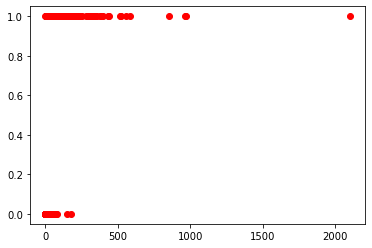

In [57]:
# Visualizing the Training set results

plt.scatter(basic_X_train['box_office'], basic_y_train, color='red')
plt.plot(basic_X_train['box_office'].values.reshape(-1, 1), regressor.predict(basic_X_train['box_office']), color='blue')
plt.title('Box Office vs Budget (Training Set)')
plt.xlabel('Budget')
plt.ylabel('Box Office')

plt.show()

# Visualizing the Test set results

plt.scatter(basic_X_validate['box_office'], basic_y_validate, color='red')
plt.plot(basic_X_train['box_office'].values.reshape(-1, 1), regressor.predict(basic_X_train['box_office']), color='blue')
plt.title('Box Office vs Budget (Test Set)')
plt.xlabel('Budget')
plt.ylabel('Box Office')

plt.show()

# Ridge Regression

In [14]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [15]:
x, y = train.box_office, train.success
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15)
x = np.array(x).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

In [16]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1,0.5, 1]
alphas = np.array(alphas).reshape(-1, 1)
alphas

array([[1.e-06],
       [1.e-05],
       [1.e-04],
       [1.e-03],
       [1.e-02],
       [1.e-01],
       [5.e-01],
       [1.e+00]])

In [17]:
x.shape, y.shape, alphas.shape

((961, 1), (961, 1), (8, 1))

In [18]:
for a in alphas:
 model = Ridge(alpha=a, normalize=True).fit(x,y)
 score = model.score(x, y)
 pred_y = model.predict(x)
 mse = mean_squared_error(y, pred_y) 
 print(f"Alpha  :  {a},   R2  :  {score},   MSE   :   {mse},   RMSE   :   {np.sqrt(mse)}")

Alpha  :  [1.e-06],   R2  :  0.17592282873741505,   MSE   :   0.20306905654869947,   RMSE   :   0.4506318414722815
Alpha  :  [1.e-05],   R2  :  0.1759228287199992,   MSE   :   0.2030690565529911,   RMSE   :   0.4506318414770433
Alpha  :  [0.0001],   R2  :  0.17592282697871453,   MSE   :   0.20306905698207836,   RMSE   :   0.45063184195313843
Alpha  :  [0.001],   R2  :  0.17592265316608102,   MSE   :   0.20306909981297908,   RMSE   :   0.4506318894762987
Alpha  :  [0.01],   R2  :  0.17590558309218984,   MSE   :   0.20307330621975891,   RMSE   :   0.45063655668371927
Alpha  :  [0.1],   R2  :  0.17446892106207368,   MSE   :   0.20342732840749655,   RMSE   :   0.4510291879773376
Alpha  :  [0.5],   R2  :  0.15637584776674762,   MSE   :   0.20788582265084407,   RMSE   :   0.45594497765722136
Alpha  :  [1.],   R2  :  0.1319421215531934,   MSE   :   0.21390678027857898,   RMSE   :   0.46250057327378413


In [19]:
X = train['box_office']
y = train['success']

X = np.array(X).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)


In [20]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print("RMSE value of training data : ", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print("R2 score value of training data : ",r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print("RMSE value of testing data : ",np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print("R2 score value of testing data : ",r2_score(y_test, pred_test_lasso))

RMSE value of training data :  0.45318799514739466
R2 score value of training data :  0.16606543694518028
RMSE value of testing data :  0.4479581521217403
R2 score value of testing data :  0.1867300440607449


In [21]:
from sklearn.linear_model import Ridge
R = Ridge(alpha=0.0001)

In [22]:
R.fit(basic_X_train, basic_y_train)

Ridge(alpha=0.0001)

In [23]:
y_pred1 = R.predict(basic_X_validate)

In [24]:
print("R2 score", r2_score(basic_y_validate, y_pred1))
print("RMSE", np.sqrt(mean_squared_error(basic_y_validate, y_pred1)))

R2 score 0.051496627985832766
RMSE 0.48118256516116625


In [25]:
basic_X_validate.shape, basic_y_validate.shape, basic_X_validate.info(), basic_y_validate

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 348 to 734
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   runtime     241 non-null    int32  
 1   budget      241 non-null    float64
 2   box_office  241 non-null    float64
 3   votes       241 non-null    int64  
dtypes: float64(2), int32(1), int64(1)
memory usage: 8.5 KB


((241, 4),
 (241,),
 None,
 348    1
 132    0
 532    0
 386    0
 325    1
       ..
 421    0
 2      1
 375    1
 262    0
 734    1
 Name: success, Length: 241, dtype: int32)

In [26]:
basic_X_validate['budget']

348    64.00
132    19.00
532     3.75
386    11.00
325    30.00
       ...  
421     5.00
2      18.00
375    12.00
262     3.00
734    20.00
Name: budget, Length: 241, dtype: float64

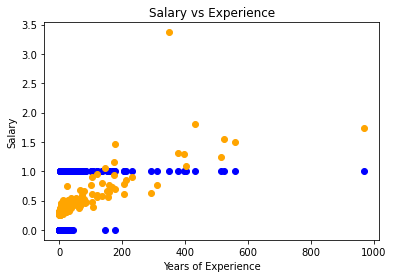

In [27]:
# Visualization on test set     
plt.scatter( basic_X_validate['box_office'], basic_y_validate, color = 'blue' )    
plt.scatter( basic_X_validate['box_office'], y_pred1, color = 'orange' )    
plt.title( 'Salary vs Experience' )    
plt.xlabel( 'Years of Experience' )    
plt.ylabel( 'Salary' )    
plt.show()

# Grid LogReg

In [29]:
logreg2 = LogisticRegression(C = 0.001, penalty="l2")
logreg2.fit(basic_X_train, basic_y_train)
print("score", logreg2.score(basic_X_train, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [241, 720]

In [ ]:
train

In [ ]:
# Random Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators=100)

In [ ]:
#training the model
regressor.fit(basic_X_train, basic_y_train)

In [ ]:
#Prediction on test data
test_data_prediction = regressor.predict(basic_X_validate)

In [ ]:
print(test_data_prediction)

In [ ]:
error_score = metrics.r2_score(basic_y_validate, test_data_prediction)
print("R squared error : ", error_score)

In [ ]:
basic_y_validate = list(basic_y_validate)

In [ ]:
plt.plot(basic_y_validate, color='red', label = 'Actual Value')
plt.plot(test_data_prediction, color='yellow', label='Predicted Values')
plt.title('Actual Box Office vs Predicted Box Office')
plt.xlabel('Number of values')
plt.ylabel('Success')
plt.legend()
plt.show()

In [ ]:
genres_df = pd.read_csv('bollywood_data.csv')
genres_df

In [ ]:
#Droping columns which are not useful
genres_df = genres_df.drop(['title_x','title_y', 'imdb_id', 'poster_path', 'wiki_link', 'is_adult', 'tagline', 'release_date', 'story', 'summary'], axis=1)

In [ ]:
#Renaming columns for ease of references
genres_df = genres_df.rename(columns={'original_title':'title', 'year_of_release':'year', 'imdb_rating':'rating', 'imdb_rating':'rating', 'imdb_votes':'votes', 'wins_nominations':'awards'})


In [ ]:
#Data cleaning
genres_df['box_office'] = genres_df['box office']
genres_df = genres_df.drop(['box office'], axis = 1)
genres_df['awards'] = genres_df['awards'].apply(lambda x : re.sub(r'[A-Za-z]', '', str(x)))

genres_df[['wins', 'nominations']] = genres_df.awards.str.split('&', expand= True)

genres_df['wins'] = genres_df['wins'].str.strip()
genres_df['wins'] = genres_df['wins'].apply(lambda x: 0 if x=='' else x)
genres_df['wins'] = genres_df['wins'].replace(np.nan, 0)
genres_df['wins'] = genres_df['wins'].astype(int)
genres_df['nominations'] = genres_df['nominations'].replace(np.nan, 0)
genres_df['nominations'] = genres_df['nominations'].astype(int)

genres_df['runtime'] = genres_df['runtime'].replace('\\N', np.nan)
genres_df['runtime'] = genres_df['runtime'].ffill()
genres_df['runtime'] = genres_df['runtime'].astype(int)
genres_df = genres_df[genres_df['runtime'] >= 60]

actors = genres_df.actors.str.split('|', expand=True)

genres_df = genres_df.drop(['awards', 'actors', 'nominations'], axis=1)

genres_df = genres_df[genres_df['year'] >= 2009]
genres_df = genres_df.drop_duplicates()

genres_df["success"] = np.where(
   (genres_df.box_office > genres_df.budget), 
   "1", 
   "0"
)
genres_df['success'] = genres_df['success'].astype(int)

In [ ]:
Action = []
Adventure = []
Animation = []
Biography = []
Comedy = []
Crime = []
Drama = []
Family = []
Fantasy = []
History = []
Horror = []
Music = []
Musical = []
Mystery = []
Romance = []
SciFi = []
Short = []
Sport = []
Thriller = []
War = []
for row in genres_df['genres']:
    row == row.split("|")
    if 'Action' in row: 
        
        Action.append('1')
    else:
        Action.append('0')
    if 'Adventure' in row:    
        Adventure.append('1')
    else:
        Adventure.append('0')
    if 'Animation' in row:    
        Animation.append('1')
    else:
        Animation.append('0')
    if 'Biography' in row:    
        Biography.append('1')
    else:
        Biography.append('0')
    if 'Comedy' in row:    
        Comedy.append('1')
    else:
        Comedy.append('0')
    if 'Crime' in row:    
        Crime.append('1')
    else:
        Crime.append('0')
    if 'Drama' in row:    
        Drama.append('1')
    else:
        Drama.append('0')
    if 'Family' in row:    
        Family.append('1')
    else:
        Family.append('0')
    if 'Fantasy' in row:    
        Fantasy.append('1')
    else:
        Fantasy.append('0')
    if 'History' in row:    
        History.append('1')
    else:
        History.append('0')    
    if 'Horror' in row:    
        Horror.append('1')
    else:
        Horror.append('0') 
    if 'Music' in row:    
        Music.append('1')
    else:
        Music.append('0')
    if 'Musical' in row:    
        Musical.append('1')
    else:
        Musical.append('0')
    if 'Mystery' in row:    
        Mystery.append('1')
    else:
        Mystery.append('0')
    if 'Romance' in row:    
        Romance.append('1')
    else:
        Romance.append('0')
    if 'Sci-Fi' in row:    
        SciFi.append('1')
    else:
        SciFi.append('0')
    if 'Short' in row:    
        Short.append('1')
    else:
        Short.append('0')
    if 'Sport' in row:    
        Sport.append('1')
    else:
        Sport.append('0')
    if 'Thriller' in row:    
        Thriller.append('1')
    else:
        Thriller.append('0')
    if 'War' in row:    
        War.append('1')
    else:
        War.append('0')
        
genres_df["Action"] = Action
genres_df["Adventure"] = Adventure
genres_df["Animation"] = Animation
genres_df["Biography"] = Biography
genres_df["Comedy"] = Comedy
genres_df["Crime"] = Crime
genres_df["Drama"] = Drama
genres_df["Family"] = Family
genres_df["Fantasy"] = Fantasy
genres_df["History"] = History
genres_df["Horror"] = Horror
genres_df["Music"] = Music
genres_df["Musical"] = Musical
genres_df["Mystery"] = Mystery
genres_df["Romance"] = Romance
genres_df["Sci-Fi"] = SciFi
genres_df["Short"] = Short
genres_df["Sport"] = Sport
genres_df["Thriller"] = Thriller
genres_df["War"] = War

genres_df['Action'] =genres_df['Action'].astype(int)
genres_df['Adventure'] =genres_df['Adventure'].astype(int)
genres_df['Animation'] =genres_df['Animation'].astype(int)
genres_df['Biography'] =genres_df['Biography'].astype(int)
genres_df['Comedy'] =genres_df['Comedy'].astype(int)
genres_df['Crime'] =genres_df['Crime'].astype(int)
genres_df['Drama'] =genres_df['Drama'].astype(int)
genres_df['Family'] =genres_df['Family'].astype(int)
genres_df['Fantasy'] =genres_df['Fantasy'].astype(int)
genres_df['History'] =genres_df['History'].astype(int)
genres_df['Horror'] =genres_df['Horror'].astype(int)
genres_df['Music'] =genres_df['Music'].astype(int)
genres_df['Musical'] =genres_df['Musical'].astype(int)
genres_df['Mystery'] =genres_df['Mystery'].astype(int)
genres_df['Romance'] =genres_df['Romance'].astype(int)
genres_df['Sci-Fi'] =genres_df['Sci-Fi'].astype(int)
genres_df['Short'] =genres_df['Short'].astype(int)
genres_df['Sport'] =genres_df['Sport'].astype(int)
genres_df['Thriller'] =genres_df['Thriller'].astype(int)
genres_df['War'] =genres_df['War'].astype(int)

genres_df = genres_df.drop(['genres'], axis=1)

In [ ]:
genres_df.info()

# Ridge Regression